In [6]:
%pip install -U torch torchvisio

ERROR: Could not find a version that satisfies the requirement torchvisio (from versions: none)
ERROR: No matching distribution found for torchvisio
Note: you may need to restart the kernel to use updated packages.



0: 480x640 1 person, 1 mouse, 128.8ms
Speed: 9.1ms preprocess, 128.8ms inference, 11.3ms postprocess per image at shape (1, 3, 480, 640)
Detected: mouse with confidence: 0.56

0: 1024x1024 1 0, 9881.3ms
Speed: 7.6ms preprocess, 9881.3ms inference, 40.9ms postprocess per image at shape (1, 3, 1024, 1024)

Mouse measurements:
Length: 1811.00 pixels
Width: 1811.00 pixels
Height: 1338.00 pixels
Mask Area: 1596486.50 square pixels
Perimeter: 5222.60 pixels


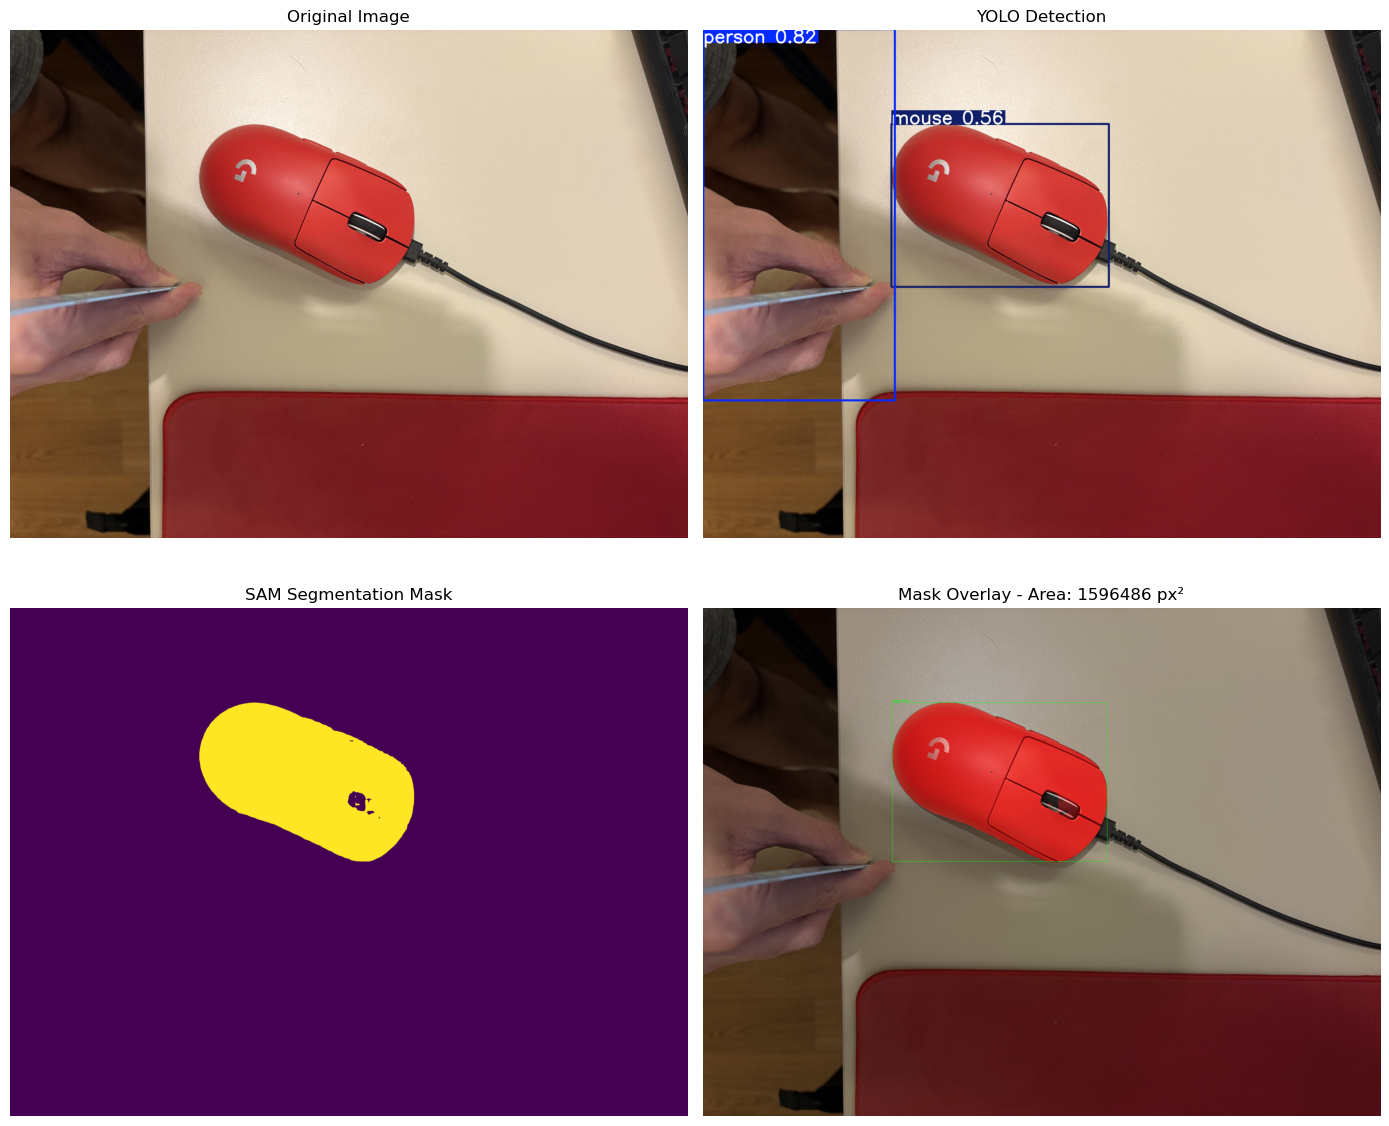


Mask shape: (4284, 5712)
Unique mask values: [False  True]


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO, SAM

def measure_object_yolo_sam(image_path, yolo_model='yolov8n.pt', sam_model='sam_b.pt'):
    """
    Detect mouse using YOLO and segment using SAM
    
    Args:
        image_path: Path to the image
        yolo_model: YOLO model path (default: yolov8n.pt)
        sam_model: SAM model path (default: sam_b.pt for base model)
    """
    # Load models
    yolo = YOLO(yolo_model)
    sam = SAM(sam_model)
    
    # Read the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Run YOLO inference
    yolo_results = yolo(img)
    result = yolo_results[0]
    
    # Filter for 'mouse' class
    mouse_detections = []
    for box in result.boxes:
        class_id = int(box.cls[0])
        class_name = result.names[class_id]
        confidence = float(box.conf[0])
        
        if class_name == 'mouse' or class_id == 64:
            mouse_detections.append(box)
            print(f"Detected: {class_name} with confidence: {confidence:.2f}")
    
    if not mouse_detections:
        print("No mouse detected. Showing all detections:")
        for box in result.boxes:
            class_id = int(box.cls[0])
            class_name = result.names[class_id]
            confidence = float(box.conf[0])
            print(f"  - {class_name} (confidence: {confidence:.2f})")
        mouse_detections = result.boxes
    
    if len(mouse_detections) > 0:
        # Get the box with highest confidence
        best_box = max(mouse_detections, key=lambda x: x.conf[0])
        x1, y1, x2, y2 = best_box.xyxy[0].cpu().numpy()
        
        # Use bounding box as prompt for SAM
        bbox = [int(x1), int(y1), int(x2), int(y2)]
        
        # Run SAM segmentation with bbox prompt
        sam_results = sam(img, bboxes=[bbox])
        
        # Get the mask
        if sam_results[0].masks is not None:
            mask = sam_results[0].masks.data[0].cpu().numpy()
            
            # Calculate measurements from mask
            mask_binary = (mask > 0.5).astype(np.uint8)
            contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
                length_pixels = max(w, h)
                
                # Calculate mask area and perimeter
                mask_area = cv2.contourArea(largest_contour)
                perimeter = cv2.arcLength(largest_contour, True)
                
                print(f"\nMouse measurements:")
                print(f"Length: {length_pixels:.2f} pixels")
                print(f"Width: {w:.2f} pixels")
                print(f"Height: {h:.2f} pixels")
                print(f"Mask Area: {mask_area:.2f} square pixels")
                print(f"Perimeter: {perimeter:.2f} pixels")
                
                # Create visualization
                fig, axes = plt.subplots(2, 2, figsize=(14, 12))
                
                # Original image
                axes[0, 0].imshow(img_rgb)
                axes[0, 0].set_title('Original Image')
                axes[0, 0].axis('off')
                
                # YOLO detection
                yolo_annotated = result.plot()
                yolo_annotated_rgb = cv2.cvtColor(yolo_annotated, cv2.COLOR_BGR2RGB)
                axes[0, 1].imshow(yolo_annotated_rgb)
                axes[0, 1].set_title('YOLO Detection')
                axes[0, 1].axis('off')
                
                # SAM mask
                axes[1, 0].imshow(mask, cmap='viridis')
                axes[1, 0].set_title('SAM Segmentation Mask')
                axes[1, 0].axis('off')
                
                # Overlay mask on original
                overlay = img_rgb.copy()
                mask_colored = np.zeros_like(img_rgb)
                mask_colored[:, :, 0] = mask * 255  # Red channel
                overlay = cv2.addWeighted(overlay, 0.7, mask_colored, 0.3, 0)
                
                # Draw bounding box on overlay
                cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(overlay, f'Length: {length_pixels:.0f}px', (x, y-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                
                axes[1, 1].imshow(overlay)
                axes[1, 1].set_title(f'Mask Overlay - Area: {mask_area:.0f} px²')
                axes[1, 1].axis('off')
                
                plt.tight_layout()
                plt.show()
                
                return {
                    'length': length_pixels,
                    'width': w,
                    'height': h,
                    'area': mask_area,
                    'perimeter': perimeter,
                    'mask': mask,
                    'bbox': bbox
                }
        else:
            print("SAM segmentation failed")
            return None
    else:
        print("No detections found")
        return None

# Install required packages if needed
# !pip install ultralytics

# Usage - Models will download automatically on first run
# SAM models: 'sam_b.pt' (base), 'sam_l.pt' (large)
result = measure_object_yolo_sam('mouse.jpg', sam_model='sam_b.pt')

if result is not None:
    print(f"\nMask shape: {result['mask'].shape}")
    print(f"Unique mask values: {np.unique(result['mask'])}")